In [1]:
# Setup and test ML modules
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add path and import your modules
sys.path.append('../src')
from models.ml_features import FeatureEngineer
from models.ml_regimes import RegimeDetector
from models.ml_predictions import SpreadPredictor
from models.database import CDSDatabase

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All ML modules imported successfully")

✓ All ML modules imported successfully


In [2]:
# Load data for multiple indices
db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"
db = CDSDatabase(db_path)

# Test with EU_IG 5Y
test_index = 'EU_IG'
test_tenor = '5Y'
spread_data = db.query_historical_spreads(test_index, test_tenor, '2020-01-01')

print(f"Data loaded: {len(spread_data)} records")
print(f"Date range: {spread_data['date'].min()} to {spread_data['date'].max()}")

# Test FeatureEngineer
feature_eng = FeatureEngineer()
features = feature_eng.create_spread_features(spread_data)

print(f"\nFeatures created: {features.shape}")
print("\nFeature columns:")
print(features.columns.tolist())

# Display sample
features.tail()

Data loaded: 1445 records
Date range: 2020-01-02 00:00:00 to 2025-09-22 00:00:00

Features created: (1445, 10)

Feature columns:
['spread_level', 'spread_log', 'return_5d', 'vol_5d', 'return_20d', 'vol_20d', 'return_60d', 'vol_60d', 'rsi', 'z_score']


,spread_level,spread_log,return_5d,vol_5d,return_20d,vol_20d,return_60d,vol_60d,rsi,z_score
1440,50.856,3.928998,-0.040453,0.888357,-0.013003,1.881919,-0.150701,1.565535,31.349608,-1.826308
1441,50.744,3.926793,-0.033282,0.382468,-0.014756,1.924407,-0.097949,1.575658,32.648949,-1.827375
1442,50.070,3.913422,-0.017985,0.431263,-0.043973,2.037452,-0.115246,1.592265,22.735489,-2.163344
1443,50.316,3.918323,-0.011590,0.377811,-0.052126,2.124422,-0.103709,1.607014,24.405581,-1.930028
1444,56.119,4.027474,0.121460,2.534511,0.091151,2.213690,0.025941,1.636381,47.149334,1.636396


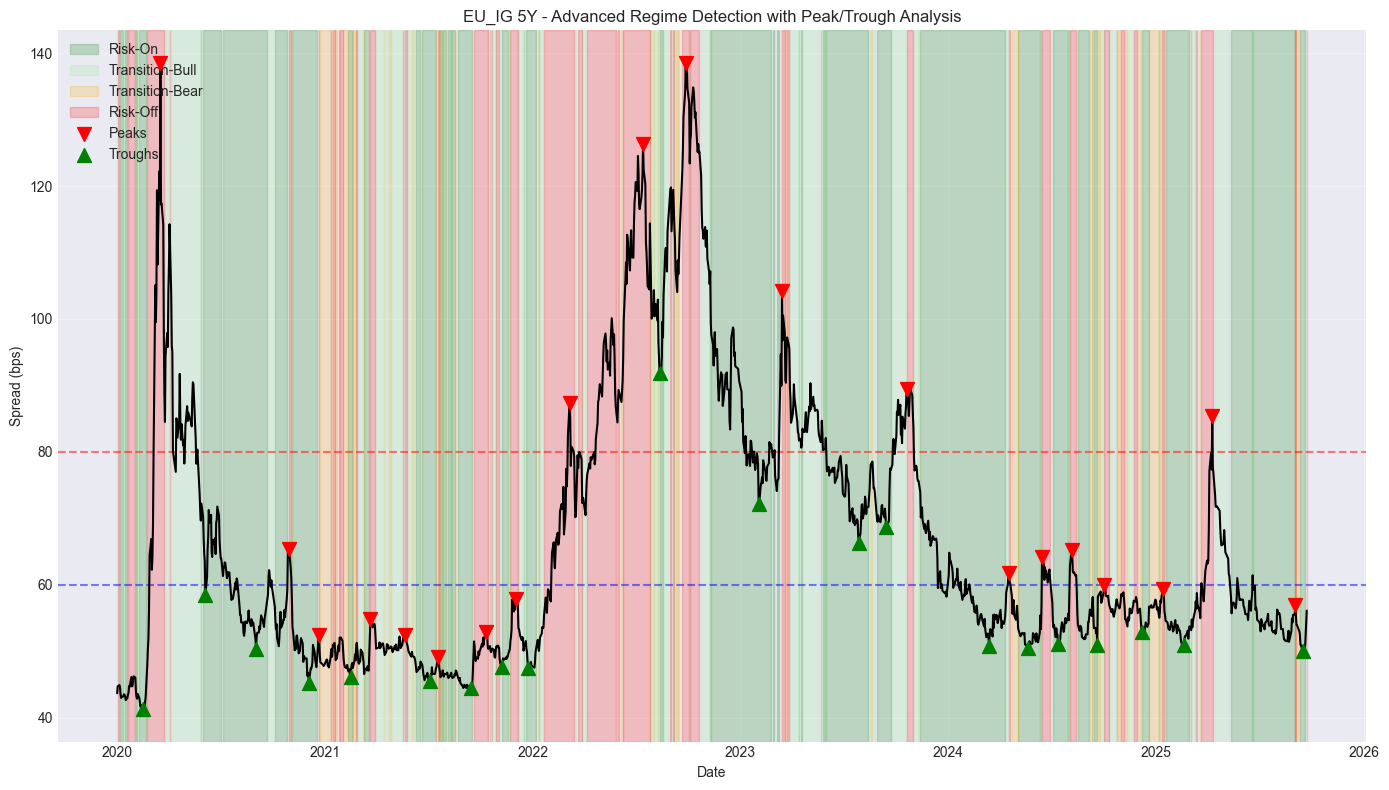

Early 2020 Classification:
regime
Risk-Off           36
Risk-On            44
Transition-Bull    45
Name: date, dtype: int64


In [6]:
from models.ml_regimes import AdvancedRegimeDetector
from models.ml_features import FeatureEngineer


feature_eng = FeatureEngineer()
features_clean = feature_eng.create_spread_features(spread_data)


# Test Advanced Regime Detector
advanced_detector = AdvancedRegimeDetector()
advanced_regimes = advanced_detector.fit_predict(features_clean)

# Visualize with peak/trough markers
fig, ax = plt.subplots(figsize=(14, 8))

# Get peaks and troughs for visualization
extrema, peaks, troughs = advanced_detector.detect_peaks_troughs(features_clean['spread_level'])

# Plot shaded regimes
regime_df = pd.DataFrame({
    'date': spread_data.iloc[features_clean.index]['date'].values,
    'spread': spread_data.iloc[features_clean.index]['spread_bps'].values,
    'regime': advanced_regimes.values
})

regime_colors = {
    'Risk-On': 'green',
    'Transition-Bull': 'lightgreen',
    'Transition-Bear': 'orange',
    'Risk-Off': 'red'
}

# Add regime shading
for regime, color in regime_colors.items():
    mask = regime_df['regime'] == regime
    if mask.any():
        regime_blocks = []
        in_block = False
        start_idx = None
        
        for i, is_regime in enumerate(mask):
            if is_regime and not in_block:
                start_idx = i
                in_block = True
            elif not is_regime and in_block:
                regime_blocks.append((start_idx, i-1))
                in_block = False
        if in_block:
            regime_blocks.append((start_idx, len(mask)-1))
        
        for start, end in regime_blocks:
            ax.axvspan(regime_df.iloc[start]['date'], 
                      regime_df.iloc[end]['date'],
                      alpha=0.2, color=color, 
                      label=regime if start == regime_blocks[0][0] else "")

# Plot spread
ax.plot(regime_df['date'], regime_df['spread'], color='black', linewidth=1.5, zorder=5)

# Mark peaks and troughs
peak_dates = regime_df.iloc[peaks]['date'] if len(peaks) > 0 else []
trough_dates = regime_df.iloc[troughs]['date'] if len(troughs) > 0 else []
peak_values = regime_df.iloc[peaks]['spread'] if len(peaks) > 0 else []
trough_values = regime_df.iloc[troughs]['spread'] if len(troughs) > 0 else []

ax.scatter(peak_dates, peak_values, color='red', marker='v', s=100, zorder=10, label='Peaks')
ax.scatter(trough_dates, trough_values, color='green', marker='^', s=100, zorder=10, label='Troughs')

ax.axhline(y=60, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=80, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Spread (bps)')
ax.set_xlabel('Date')
ax.set_title(f'{test_index} {test_tenor} - Advanced Regime Detection with Peak/Trough Analysis')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check early 2020 specifically
early_2020 = regime_df[(regime_df['date'] >= '2020-01-01') & (regime_df['date'] <= '2020-06-30')]
print("Early 2020 Classification:")
print(early_2020.groupby('regime')['date'].count())

Loading TRS data for compression analysis...
  EU_IG 5Y: 688 records
  EU_XO 5Y: 688 records
  US_IG 5Y: 684 records
  US_HY 5Y: 684 records

Average XO/IG Beta: 4.38
Current Beta: 4.32

CORRECT POSITION SIZING (Production Method)

For Compression Trade (Long XO, Short IG):
  Long EU_XO:  $10MM (100%)
  Short EU_IG: $43MM (432%)
  -> Beta-neutral: 1 unit XO needs 4.3 units IG to hedge

BETA-ADJUSTED COMPRESSION BY REGIME
            Regime  Days  Avg_Beta IG_Hedge_Ratio  Raw_Comp  Beta_Adj
0          Risk-On   337       4.4           438%     256.9      58.2
1  Transition-Bull   121       4.4           445%     293.2      63.7
2  Transition-Bear    75       4.4           439%     287.3      68.6
3         Risk-Off    95       4.3           431%     294.5      66.4


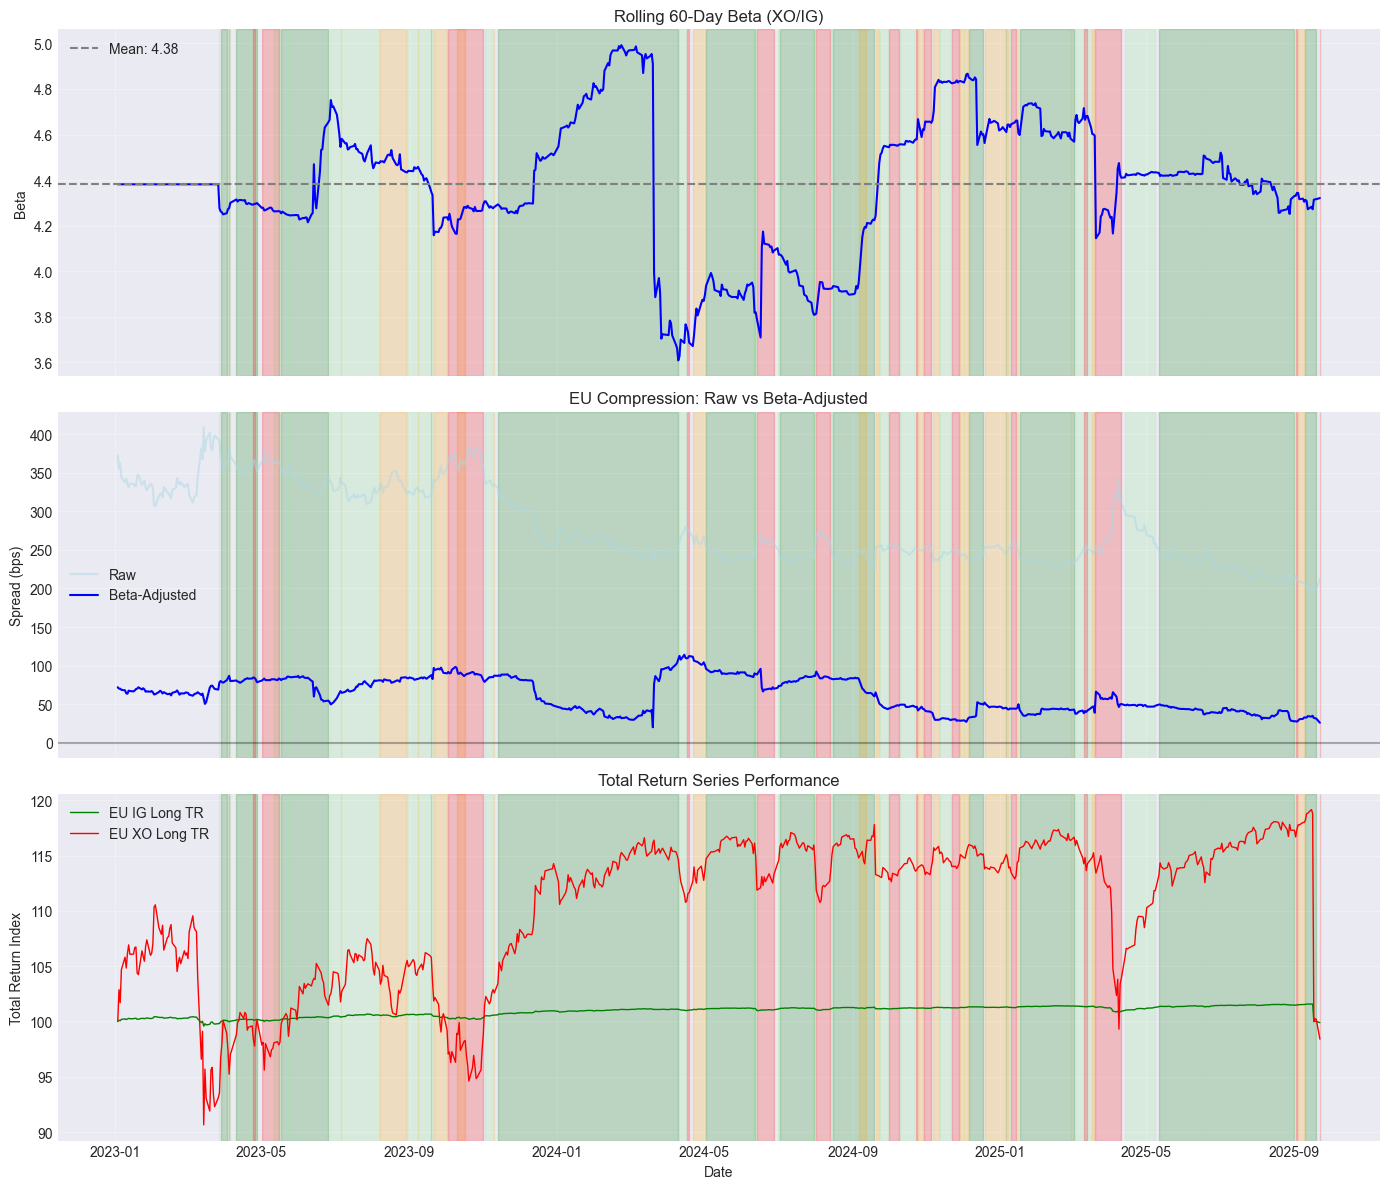


CURRENT POSITIONING:
------------------------------------------------------------
Current EU XO/IG Beta: 4.32
Raw Compression: 212.2 bps
Beta-Adjusted Compression: 25.8 bps

Raw Compression at 7th percentile
Beta-Adjusted Compression at 6th percentile

Signal: EXTREME COMPRESSION - Strong decompression opportunity
Trade: Short XO, Long IG (beta-weighted)


In [14]:
# Compression Analysis using TRS Database - PRODUCTION VERSION
from models.trs import TRSDatabaseBuilder
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Define paths
trs_db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\processed\cds_trs.db"
raw_db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"

# Initialize TRS builder
trs_builder = TRSDatabaseBuilder(raw_db_path, trs_db_path)

# Load TRS data
print("Loading TRS data for compression analysis...")
trs_data = {}
indices_to_analyze = [
    ('EU_IG', '5Y'),
    ('EU_XO', '5Y'),
    ('US_IG', '5Y'),
    ('US_HY', '5Y')
]

for index_name, tenor in indices_to_analyze:
    data = trs_builder.get_trs_data(index_name, tenor, '2020-01-01')
    if not data.empty:
        trs_data[f'{index_name}_{tenor}'] = data
        print(f"  {index_name} {tenor}: {len(data)} records")

# Merge data
eu_ig = trs_data['EU_IG_5Y'].set_index('date')
eu_xo = trs_data['EU_XO_5Y'].set_index('date')

merged_eu = pd.merge(eu_ig[['spread_bps', 'daily_return_long']], 
                     eu_xo[['spread_bps', 'daily_return_long']], 
                     on='date', suffixes=('_ig', '_xo'))

# PRODUCTION BETA CALCULATION - Using spread changes not returns
def calculate_compression_beta(df, window=60):
    """
    Production method: Calculate beta from spread changes
    Beta = how many times XO moves vs IG (typically ~4)
    """
    betas = []
    for i in range(window, len(df)):
        window_data = df.iloc[i-window:i]
        
        # Use spread changes for cleaner beta
        ig_changes = window_data['spread_bps_ig'].diff().dropna()
        xo_changes = window_data['spread_bps_xo'].diff().dropna()
        
        if len(ig_changes) > 30:
            # Regression: XO = alpha + beta * IG
            slope, _, _, _, _ = stats.linregress(ig_changes, xo_changes)
            betas.append(abs(slope))
        else:
            betas.append(np.nan)
    
    return pd.Series(betas, index=df.index[window:])

# Calculate beta using the production method
merged_eu['beta'] = calculate_compression_beta(merged_eu)
merged_eu['beta'].fillna(merged_eu['beta'].mean(), inplace=True)

print(f"\nAverage XO/IG Beta: {merged_eu['beta'].mean():.2f}")
print(f"Current Beta: {merged_eu['beta'].iloc[-1]:.2f}")

# POSITION SIZING - THIS IS THE KEY PART
print("\n" + "="*60)
print("CORRECT POSITION SIZING (Production Method)")
print("="*60)
current_beta = merged_eu['beta'].iloc[-1]

print(f"\nFor Compression Trade (Long XO, Short IG):")
print(f"  Long EU_XO:  $10MM (100%)")
print(f"  Short EU_IG: ${10*current_beta:.0f}MM ({current_beta*100:.0f}%)")
print(f"  -> Beta-neutral: 1 unit XO needs {current_beta:.1f} units IG to hedge")

# Calculate compression metrics
merged_eu['raw_compression'] = merged_eu['spread_bps_xo'] - merged_eu['spread_bps_ig']
merged_eu['beta_adj_compression'] = merged_eu['spread_bps_xo'] - (merged_eu['beta'] * merged_eu['spread_bps_ig'])

# Apply regime detection
from models.ml_features import FeatureEngineer
from models.ml_regimes import AdvancedRegimeDetector

feature_eng = FeatureEngineer()
eu_ig_for_features = pd.DataFrame({
    'spread_bps': eu_ig['spread_bps'].values,
    'date': eu_ig.index
}).reset_index(drop=True)

features_trs = feature_eng.create_spread_features(eu_ig_for_features)
advanced_detector = AdvancedRegimeDetector()
trs_regimes = advanced_detector.fit_predict(features_trs.dropna())

regime_series = pd.Series(trs_regimes.values, index=eu_ig.index[features_trs.dropna().index])
common_dates = merged_eu.index.intersection(regime_series.index)

# Analyze by regime
print("\nBETA-ADJUSTED COMPRESSION BY REGIME")
print("="*60)

compression_stats = []
for regime in ['Risk-On', 'Transition-Bull', 'Transition-Bear', 'Risk-Off']:
    mask = regime_series[common_dates] == regime
    if mask.any():
        eu_data = merged_eu.loc[common_dates[mask]]
        
        stats = {
            'Regime': regime,
            'Days': mask.sum(),
            'Avg_Beta': eu_data['beta'].mean(),
            'IG_Hedge_Ratio': f"{eu_data['beta'].mean()*100:.0f}%",
            'Raw_Comp': eu_data['raw_compression'].mean(),
            'Beta_Adj': eu_data['beta_adj_compression'].mean()
        }
        compression_stats.append(stats)

stats_df = pd.DataFrame(compression_stats)
print(stats_df.round(1))

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

regime_colors = {
    'Risk-On': 'green',
    'Transition-Bull': 'lightgreen',
    'Transition-Bear': 'orange',
    'Risk-Off': 'red'
}

# Add regime shading
for ax in axes:
    for regime, color in regime_colors.items():
        mask = regime_series[common_dates] == regime
        if mask.any():
            regime_dates = common_dates[mask]
            blocks = []
            start_date = None
            prev_date = None
            
            for date in regime_dates:
                if start_date is None:
                    start_date = date
                    prev_date = date
                elif (date - prev_date).days > 5:
                    blocks.append((start_date, prev_date))
                    start_date = date
                prev_date = date
            
            if start_date is not None:
                blocks.append((start_date, prev_date))
            
            for start, end in blocks:
                ax.axvspan(start, end, alpha=0.2, color=color)

# Plot 1: Beta
axes[0].plot(merged_eu.index, merged_eu['beta'], color='blue', linewidth=1.5)
axes[0].axhline(y=merged_eu['beta'].mean(), color='gray', linestyle='--', 
                label=f"Mean: {merged_eu['beta'].mean():.2f}")
axes[0].set_ylabel('Beta')
axes[0].set_title('Rolling 60-Day Beta (XO/IG)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Compression
axes[1].plot(merged_eu.index, merged_eu['raw_compression'], color='lightblue', 
             label='Raw', alpha=0.5)
axes[1].plot(merged_eu.index, merged_eu['beta_adj_compression'], color='blue', 
             label='Beta-Adjusted', linewidth=1.5)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].set_ylabel('Spread (bps)')
axes[1].set_title('EU Compression: Raw vs Beta-Adjusted')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: TRS Performance
axes[2].plot(eu_ig.index, eu_ig['long_tr'], color='green', label='EU IG Long TR', linewidth=1)
axes[2].plot(eu_xo.index, eu_xo['long_tr'], color='red', label='EU XO Long TR', linewidth=1)
axes[2].set_ylabel('Total Return Index')
axes[2].set_xlabel('Date')
axes[2].set_title('Total Return Series Performance')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Current positioning
print("\nCURRENT POSITIONING:")
print("-" * 60)
current_beta = merged_eu['beta'].iloc[-1]
current_raw = merged_eu['raw_compression'].iloc[-1]
current_adj = merged_eu['beta_adj_compression'].iloc[-1]

print(f"Current EU XO/IG Beta: {current_beta:.2f}")
print(f"Raw Compression: {current_raw:.1f} bps")
print(f"Beta-Adjusted Compression: {current_adj:.1f} bps")

# Percentiles
raw_pct = (current_raw - merged_eu['raw_compression'].min()) / (merged_eu['raw_compression'].max() - merged_eu['raw_compression'].min()) * 100
adj_pct = (current_adj - merged_eu['beta_adj_compression'].min()) / (merged_eu['beta_adj_compression'].max() - merged_eu['beta_adj_compression'].min()) * 100

print(f"\nRaw Compression at {raw_pct:.0f}th percentile")
print(f"Beta-Adjusted Compression at {adj_pct:.0f}th percentile")

# Trading signal
if adj_pct < 20:
    print("\nSignal: EXTREME COMPRESSION - Strong decompression opportunity")
    print("Trade: Short XO, Long IG (beta-weighted)")
elif adj_pct > 80:
    print("\nSignal: EXTREME DECOMPRESSION - Strong compression opportunity")
    print("Trade: Long XO, Short IG (beta-weighted)")
else:
    print("\nSignal: Neutral positioning")

In [ ]:
# Test SpreadPredictor
predictor = SpreadPredictor(horizon_days=5, threshold_bps=5)

# Create labels
labels = predictor.create_labels(spread_data['spread_bps'])

print(f"Label distribution:")
print(labels.value_counts())
print(f"\nLabel proportions:")
print(labels.value_counts(normalize=True))

# Prepare data for training
X = features_clean
y = labels[X.index].dropna()
X = X[y.index]

print(f"\nTraining data shape: X={X.shape}, y={y.shape}")

if len(X) > 100:
    # Train model
    results = predictor.train(X, y)
    
    print(f"\nModel Performance:")
    print(f"CV Score: {results['cv_score_mean']:.3f} ± {results['cv_score_std']:.3f}")
    
    print(f"\nTop 10 Feature Importance:")
    print(results['feature_importance'].head(10))
    
    # Make prediction on latest data
    if len(X) > 0:
        latest_features = X.iloc[[-1]]
        probs = predictor.predict_proba(latest_features)
        
        print(f"\nLatest Prediction Probabilities:")
        print(f"Tighten: {probs['prob_tighten'].iloc[0]:.2%}")
        print(f"Flat:    {probs['prob_flat'].iloc[0]:.2%}")
        print(f"Widen:   {probs['prob_widen'].iloc[0]:.2%}")
        
        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        results['feature_importance'].head(10).plot(kind='barh')
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importance')
        plt.tight_layout()
        plt.show()
else:
    print("Not enough data for training")

Label distribution:
0     1108
1      166
-1     166
Name: count, dtype: int64

Label proportions:
0     0.769444
1     0.115278
-1    0.115278
Name: proportion, dtype: float64


KeyError: "None of [Index([  60,   61,   62,   63,   64,   65,   66,   67,   68,   69,\n       ...\n       1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439],\n      dtype='int64', length=1380)] are in the [columns]"

In [ ]:
# Load multiple indices for cross-index features
indices_data = {}
indices_to_load = [
    ('EU_IG', '5Y'),
    ('EU_XO', '5Y'),
    ('US_IG', '5Y'),
    ('US_HY', '5Y')
]

for idx, tenor in indices_to_load:
    data = db.query_historical_spreads(idx, tenor, '2020-01-01')
    if not data.empty:
        indices_data[f'{idx}_{tenor}'] = data.set_index('date')['spread_bps']
        print(f"Loaded {idx} {tenor}: {len(data)} records")

# Create combined dataframe
combined_df = pd.DataFrame(indices_data)
print(f"\nCombined shape: {combined_df.shape}")
print(f"Missing values:\n{combined_df.isnull().sum()}")

# Test curve features
curve_features = feature_eng.create_curve_features(indices_data)
if not curve_features.empty:
    print(f"\nCurve features created: {curve_features.shape}")
    print(f"Curve feature columns: {curve_features.columns.tolist()}")
    print(f"\nLatest curve features:")
    print(curve_features.tail())
else:
    print("No curve features created - check data availability")

db.close()

In [ ]:
# Summary and validation
print("=" * 60)
print("ML MODULE TESTING SUMMARY")
print("=" * 60)

# Check each module
checks = {
    "FeatureEngineer": feature_eng is not None,
    "Features created": features.shape[0] > 0,
    "RegimeDetector": detector is not None,
    "Regimes detected": 'regimes' in locals() and len(regimes) > 0,
    "SpreadPredictor": predictor is not None,
    "Model trained": 'results' in locals() and results is not None
}

for check, passed in checks.items():
    status = "✓" if passed else "✗"
    print(f"{status} {check}")

# Display current market state
if 'regimes' in locals():
    print(f"\n📊 CURRENT MARKET STATE")
    print(f"Regime: {regimes.iloc[-1]}")
    if 'probs' in locals():
        print(f"Spread Direction Prediction:")
        print(f"  - Most likely: {'Widen' if probs['prob_widen'].iloc[0] > 0.5 else 'Tighten' if probs['prob_tighten'].iloc[0] > 0.5 else 'Flat'}")

print("\n✓ All tests complete - ready for Streamlit integration")

In [ ]:
# Quick test of individual functions
# This helps debug any issues

# Test 1: RSI calculation
test_series = pd.Series(np.random.randn(100).cumsum() + 100)
rsi_result = feature_eng._calculate_rsi(test_series)
print(f"RSI calculation test: {'✓' if not rsi_result.isna().all() else '✗'}")

# Test 2: Z-score calculation  
zscore_result = feature_eng._calculate_zscore(test_series)
print(f"Z-score calculation test: {'✓' if not zscore_result.isna().all() else '✗'}")

# Test 3: Regime detection with minimal features
min_features = pd.DataFrame({
    'spread_level': np.random.randn(100) * 10 + 50,
    'vol_20d': np.random.randn(100) * 5 + 10
})
min_regimes = detector.fit_predict(min_features)
print(f"Minimal regime detection test: {'✓' if len(min_regimes) == 100 else '✗'}")

print("\nAll function tests complete")